In [3]:
from modules.models import KdVBurgersPinn, create_dense_model, create_dense_model_Normalized, FourierFeatures
from modules.data import simulate_kdvburgers
from modules.plots import plot_KdV_model, plot_training_loss
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [92]:
! git add KdVB.ipynb
! git commit -m "KdV-B (dissipation coeff = 0.5) with incorrect scaling of initial condition"
! git push origin main

[main 761c577] KdV-B (dissipation coeff = 0.5) with incorrect scaling of initial condition
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite PinnNew/KdVB.ipynb (89%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 8 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 265.34 KiB | 4.91 MiB/s, done.
Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/naiaseh/Trunk.git
   d64d0ba..761c577  main -> main


In [79]:
!git config --global user.name "Nadia Aiaseh"
!git config --global user.email "naiaseh@uwo.ca"


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/Trunk/PinnNew")
print(os.getcwdb())

b'/content/drive/MyDrive/Trunk/PinnNew'


In [67]:



phi = 0.
alpha = 0.
beta = 1.
gamma = 6.
c0 = 2*3.
# k = 0.4580
# k= alpha/(10*beta)

# c= 6./25. * alpha**2 / beta
# k= alpha/(10*beta)


# ### shock profile initial condition ###
# def phi_function(tx):
#     offset =  0.
#     ksi = tx[:, 1:2]-c*tx[:,0:1]+offset
#     u = 3/25 * (alpha**2)/(beta*gamma) * (1/tf.cosh(k*ksi)**2 - 2*tf.tanh(k*ksi) - 2)
#     # u = tf.where(tf.math.is_nan(u), 0., u)
#     # u = tf.where(tf.math.is_inf(u), 0., u)
#     return u

# def phi_function(tx):
#     offset =  0.
#     ksi = tx[:, 1:2]-c*tx[:,0:1]+offset
#     u = 2*k/gamma *(2 * (alpha + 2*beta*k) + (alpha + 6*beta*k) * 1/tf.cosh(k*ksi)**2 )
#     # u = tf.where(tf.math.is_nan(u), 0., u)
#     # u = tf.where(tf.math.is_inf(u), 0., u)
#     return u


# def phi_function(tx):
#   ksi = 1/2 * (-alpha/(5*beta) * tx[:,1:2] + 6 * alpha**3/(125*beta**2) * tx[:,0:1] )
#   u = 3*alpha**2/(25*gamma*beta) * 1/tf.cosh(ksi)**2 - 6*alpha**2/(25*gamma*beta) * tf.tanh(ksi) + 6*alpha**2/(25*gamma*beta)
#   return u


def phi_function(tx):
    offset =  0.
    ksi = tx[:, 1:2]-c0*tx[:,0:1]+offset
    ampl = 3*c0/gamma
    multiplier = c0/(beta*4)
    u = ampl / tf.cosh(np.sqrt(multiplier)*ksi)**2
    u = tf.where(tf.math.is_nan(u), 0., u)
    return u

def boundary_function(tx):
    return phi*tf.ones_like(tx[:, 1:])

# x_start = 0
# length = 8*np.pi
x_start =  -50. #-10
length = 50.#10
t0 = 0.
time = 5.

In [59]:
# 45/(8*alpha*3*c0)
1e-2

0.01

Text(0, 0.5, 'u(x,y,t)')

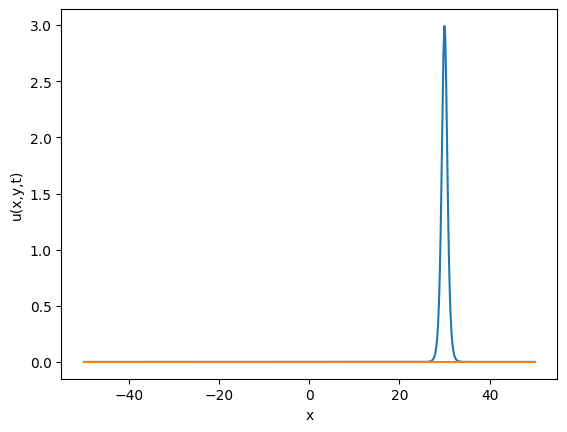

In [66]:
N = 500
TIME = 5.
xt = np.linspace(x_start,length,N).T

tt = np.zeros((N,1))
xt = xt.reshape(-1,1)

tt = tt.reshape(-1,1)
txy2 = np.stack([np.full(tt.shape, TIME),  xt ], axis=1)
txy3 = np.stack([np.full(tt.shape, time),  xt ], axis=1)
u2 = phi_function(txy2)
u2 = tf.reshape(u2, [xt.shape[0],xt.shape[1]])

u3 = phi_function(txy3)
u3 = tf.reshape(u3, [xt.shape[0],xt.shape[1]])
plt.plot(xt, u2)
plt.plot(xt, u3)

# plt.xlim([0,20])
plt.xlabel('x')
plt.ylabel('u(x,y,t)')
# plt.ylim([0,7])

In [68]:
(tx_eqn, y_eqn), (tx_init, y_init), (tx_boundary, y_boundary) = simulate_kdvburgers(30000, phi_function, boundary_function, x_start, length, t0, time, n_init = None, n_bnd = None, random_seed = 42, dtype=tf.float32)




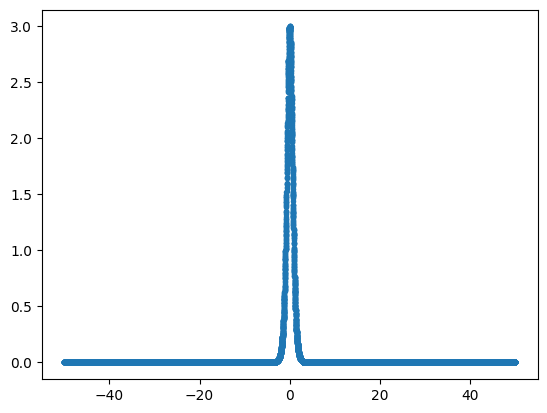

In [69]:

plt.plot( tx_init[:,1:],y_init,'.')

In [70]:
inputs = [tx_eqn, tx_init, tx_boundary]
outputs = [phi_function(tx_eqn), y_eqn, y_init, y_boundary]


In [48]:
normalizer = tf.keras.layers.Normalization(axis=1)
normalizer.adapt(tx_eqn)
tf.shape(tx_eqn)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([30000,     2], dtype=int32)>

In [93]:
backbone = create_dense_model([32, 32, 32], activation='tanh', initializer='glorot_normal',\
    n_inputs=2, n_outputs=1)
pinn = KdVBurgersPinn(backbone, alpha=0.9, beta=0.7, gamma=1.,c=0., loss_residual_weight = 1.)
a0 = 1e-3
decay_step = 1000
rate = 0.95
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(a0, decay_steps= decay_step, decay_rate= rate)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, clipnorm=1.)
pinn.compile(optimizer=optimizer)

In [94]:

history = pinn.fit_custom(inputs, outputs, epochs = 50000, print_every = 500)
# history = pinn.fit(inputs, outputs, batch_size = 30000, epochs = 4000)

Epoch 0, Loss Residual: 0.0140295047, Loss Initial: 0.3783884645, Loss Boundary: 0.3365518749, MAE: 0.6011003852
Epoch 500, Loss Residual: 0.0021178131, Loss Initial: 0.0038188447, Loss Boundary: 0.0000032285, MAE: 0.1039372757
Epoch 1000, Loss Residual: 0.0009752350, Loss Initial: 0.0007247369, Loss Boundary: 0.0000024995, MAE: 0.1023883969
Epoch 1500, Loss Residual: 0.0005414649, Loss Initial: 0.0002024941, Loss Boundary: 0.0000026450, MAE: 0.1000436544
Epoch 2000, Loss Residual: 0.0003591033, Loss Initial: 0.0000895523, Loss Boundary: 0.0000072090, MAE: 0.1003487781
Epoch 2500, Loss Residual: 0.0002618010, Loss Initial: 0.0000529858, Loss Boundary: 0.0000005992, MAE: 0.0994823053
Epoch 3000, Loss Residual: 0.0002049263, Loss Initial: 0.0000358990, Loss Boundary: 0.0000002974, MAE: 0.0993027836
Epoch 3500, Loss Residual: 0.0001660198, Loss Initial: 0.0000432796, Loss Boundary: 0.0000189983, MAE: 0.1016058251
Epoch 4000, Loss Residual: 0.0001337107, Loss Initial: 0.0000194381, Loss Bo

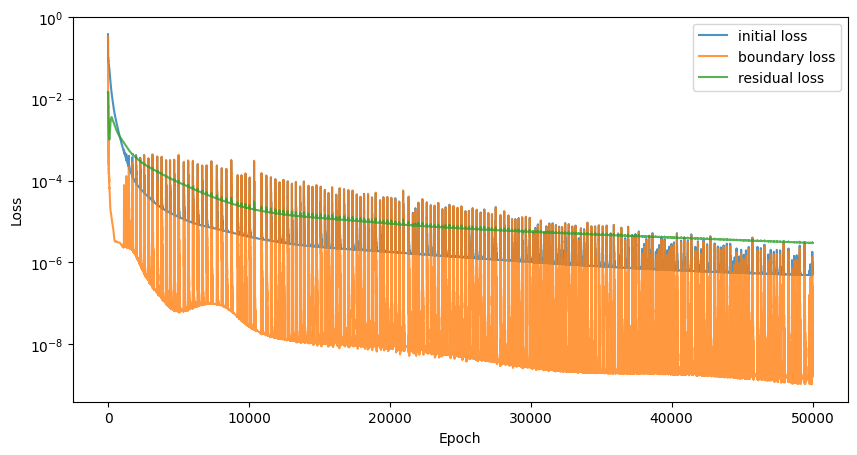

In [95]:
  history2 = {k: history[k] for k in ('loss_total', 'loss_residual', 'loss_initial', 'loss_boundary')}

  plot_training_loss(history2, y_scale='log')



Text(0, 0.5, 'MAE')

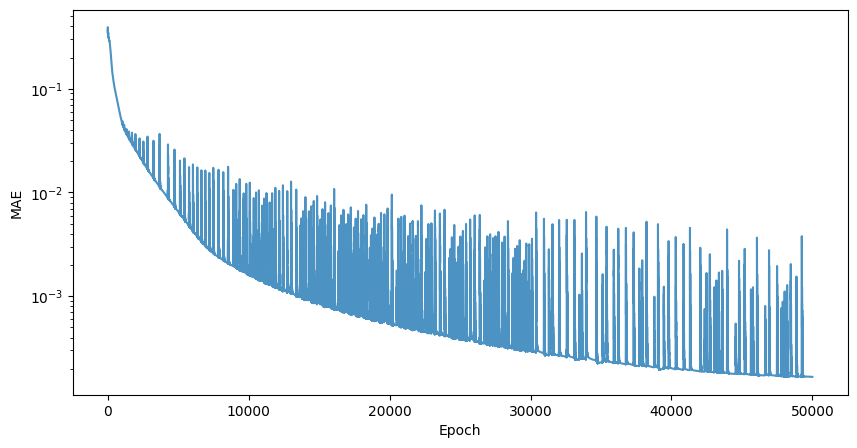

In [103]:
plt.figure(figsize=(10, 5), dpi = 100)
plt.yscale('log')
plt.plot(history['mean_absolute_error'], label='mean absolute error', alpha = 0.8)
plt.xlabel('Epoch')
plt.ylabel('MAE')

1/1 [==============================] - 0s 15ms/step


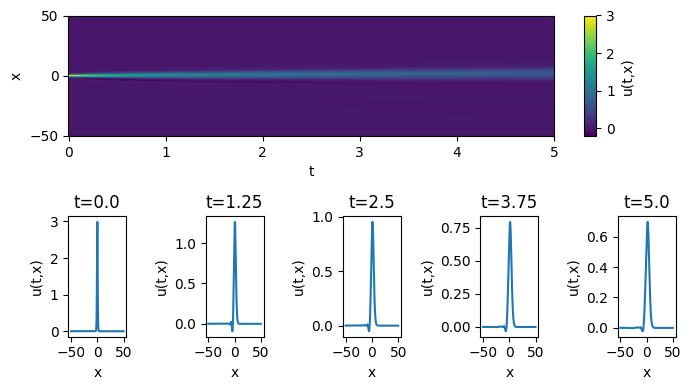

In [96]:
plot_KdV_model(pinn.backbone, x_start,length, time, -0.2, 3, t0 = t0, save_path = None, show=True)

1000/1000 [==============================] - 1s 1ms/step


Text(0, 0.5, '$t$')

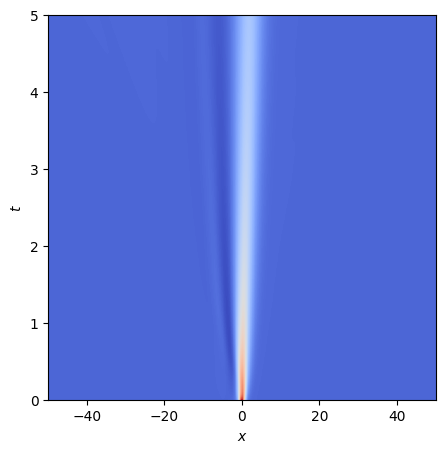

In [84]:
    from matplotlib.gridspec import GridSpec

    num_test_samples = 1000
    t_flat = np.linspace(t0, time, num_test_samples)
    x_flat = np.linspace(x_start, length, num_test_samples)
    t, x = np.meshgrid(t_flat, x_flat)
    tx = np.stack([t.flatten(), x.flatten()], axis=-1) #
    u = pinn.backbone.predict(tx, batch_size=num_test_samples)
    u = u.reshape(t.shape)

    # plot u(t,x) distribution as a color-map
    fig = plt.figure(figsize=(5,5))
    gs = GridSpec(1, 1)
    plt.subplot(gs[:, :])
    plt.pcolormesh(x, t, u, cmap = 'coolwarm', shading='auto')
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    # cbar = plt.colorbar(pad=0.05, aspect=10, locationm = None)
    # cbar.set_label('u(t,x)')
    # cbar.mappable.set_clim(-1, 3)
    # plot u(t=const, x) cross-sections

1000/1000 [==============================] - 1s 1ms/step


Text(0, 0.5, '$t$')

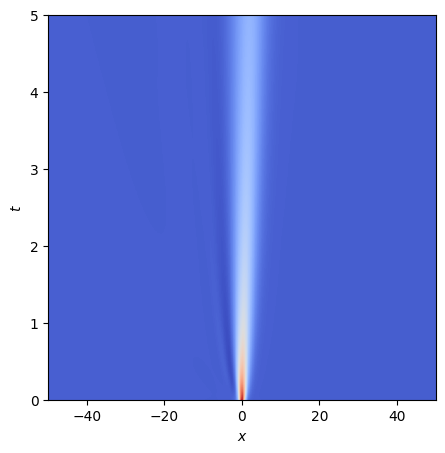

In [97]:
    from matplotlib.gridspec import GridSpec

    num_test_samples = 1000
    t_flat = np.linspace(t0, time, num_test_samples)
    x_flat = np.linspace(x_start, length, num_test_samples)
    t, x = np.meshgrid(t_flat, x_flat)
    tx = np.stack([t.flatten(), x.flatten()], axis=-1) #
    u = pinn.backbone.predict(tx, batch_size=num_test_samples)
    u = u.reshape(t.shape)

    # plot u(t,x) distribution as a color-map
    fig = plt.figure(figsize=(5,5))
    gs = GridSpec(1, 1)
    plt.subplot(gs[:, :])
    plt.pcolormesh(x, t, u, cmap = 'coolwarm', shading='auto')
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    # cbar = plt.colorbar(pad=0.05, aspect=10, locationm = None)
    # cbar.set_label('u(t,x)')
    # cbar.mappable.set_clim(-1, 3)
    # plot u(t=const, x) cross-sections

In [42]:
alpha

0.0

In [44]:
def plot_snapshots(timeList,num_test_samples = 1000, phi_function = phi_function, pinn = pinn):
    x_flat = np.linspace(x_start, length, num_test_samples)
    t_flat = np.linspace(0, time, num_test_samples)
    x_flat = tf.convert_to_tensor(x_flat)
    t_flat = tf.convert_to_tensor(t_flat)
    # t_, x_ = tf.meshgrid(t_flat, x_flat)
    # tx = tf.concat((tf.reshape(t_, (-1, 1)), tf.reshape(x_, (-1, 1))), axis=1)
    # solution = phi_function_PBC(tx,num_test_samples ,num_test_samples)
    # solution = tf.reshape(solution, x_.shape)
    dt=time/(num_test_samples-1)
    t_cross_sections = timeList
    for i, t_cs in enumerate(t_cross_sections):
        tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
        print(tx.shape)
        u = pinn.backbone.predict(tx, batch_size=num_test_samples)
        # plt.plot(x_flat, phi_function(tx),label = 'exact at time {}'.format(t_cs))
        plt.plot(x_flat, u, label = 'prediction at time {}'.format(t_cs))
        # plt.plot(x_flat, phi_function_solitonsAdded(tx),label = 'added at time {}'.format(t_cs))

        # print(int(t_cs/dt+1))
        # plt.plot(x_flat, solution[:,int(t_cs/dt)], label = 'exact')

        plt.legend()
        # plt.title('t={}'.format(np.round(t_cs,2)))
        plt.xlabel('x')
        plt.ylabel('u(t,x)')
        # plt.ylim([-0.5, 2.])
        # plt.xlim([-50,50])
    return

In [88]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 1000
xspace = np.linspace(x_start, length, N + 1)
tspace = np.linspace(t0, time, N + 1)
T, X = np.meshgrid(np.flip(tspace), xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)

upred = pinn.backbone.predict(Xgrid)

# Reshape upred
U = upred.reshape(N+1,N+1)

# Surface plot of solution u(t,x)


31313/31313 [==============================] - 37s 1ms/step


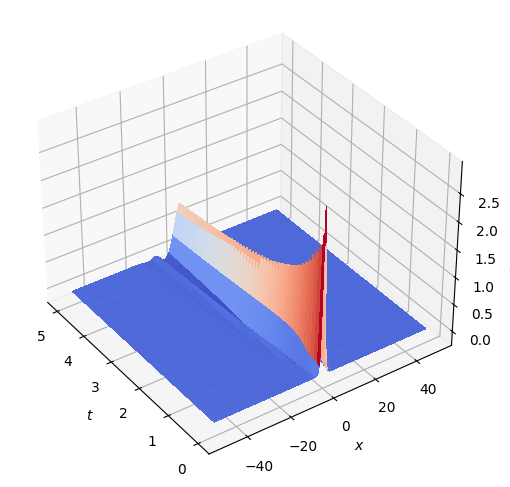

In [89]:
from matplotlib import cm
from matplotlib.colors import LightSource
from matplotlib.ticker import LinearLocator
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')


ax.plot_surface(T, X, U, cmap='coolwarm', antialiased = False, linewidth=0);
ax.view_init(35,-35,0)
# ax.view_init(90,-90,0)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u(x,t)$')
ax.invert_xaxis()
# ax.set_title('Solution of KdV equation');

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(1))

In [ ]:
import pickle
with open('KdVDoubleSolitonAdded64-128-128-128-64.pickle', 'rb') as f:
    my_weights = pickle.load(f)

pinn.backbone.set_weights(my_weights)

In [105]:
# to set

# with open('PickleFiles/KdVB/Alpha0/KdVBalpha0Time10-3x32.pickle', 'rb') as f:
#     my_weights = pickle.load(f)
# pinn.backbone.set_weights(my_weights)
# with open('PickleFiles/KdVB/Alpha0/HistoryKdVBalpha0-5Time10-3x32.pickle', 'rb') as f:
#   history = pickle.load(f)

# to write
with open('PickleFiles/KdVB/Alpha0/HistoryKdVBalpha0Time10-3x32.pickle', 'wb') as fp:
    pickle.dump(history, fp)

current_weights = pinn.backbone.get_weights()
with open('PickleFiles/KdVB/Alpha0/KdVBalpha0Time10-3x32.pickle', 'wb') as f:
    pickle.dump(current_weights, f)

(1000, 2)
1/1 [==============================] - 0s 16ms/step
(1000, 2)
1/1 [==============================] - 0s 16ms/step
(1000, 2)
1/1 [==============================] - 0s 17ms/step
(1000, 2)
1/1 [==============================] - 0s 16ms/step
(1000, 2)
1/1 [==============================] - 0s 16ms/step
(1000, 2)
1/1 [==============================] - 0s 15ms/step


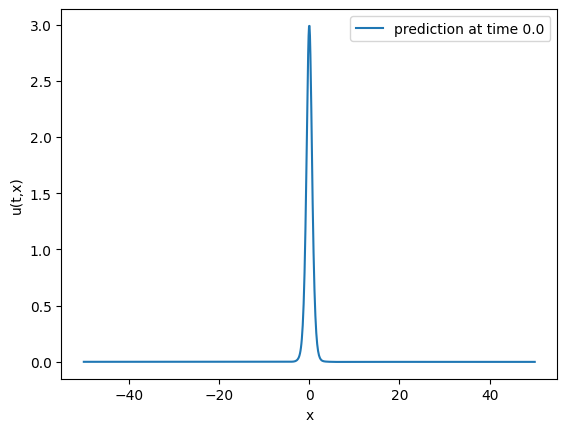

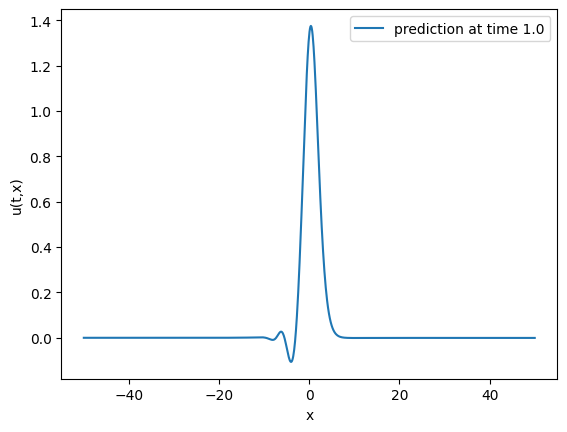

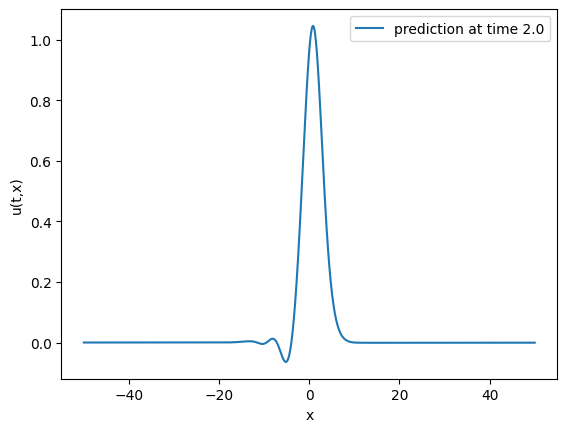

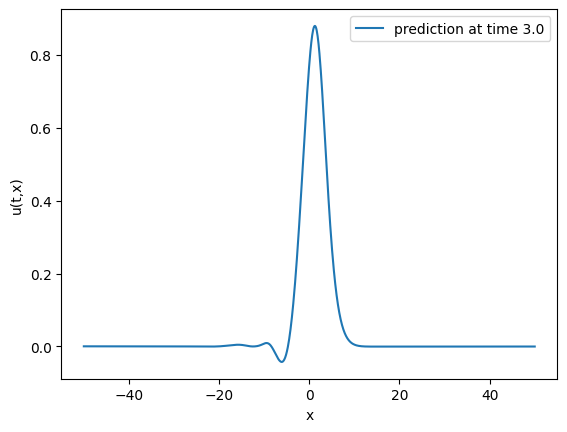

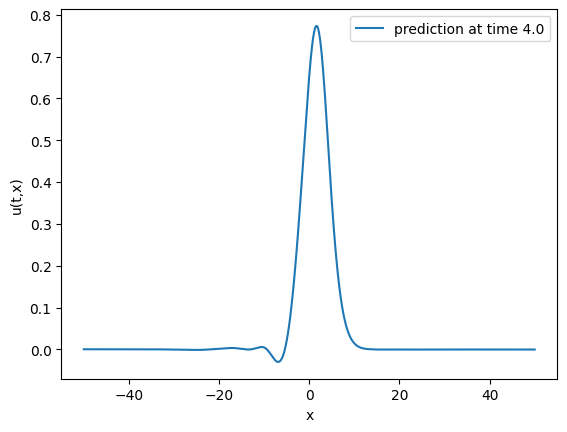

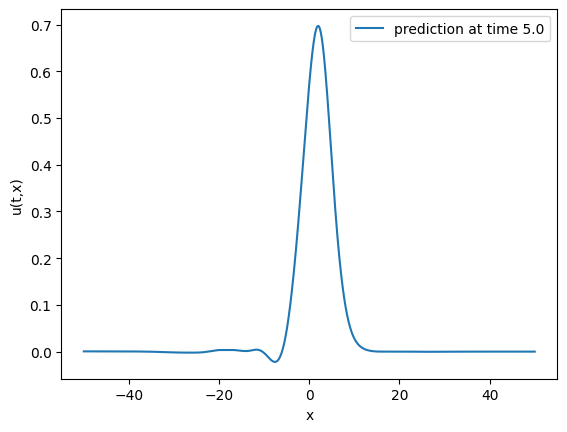

In [98]:
T = np.arange(0.,time+1,1.)
for inde, Tt in enumerate(T):
  plt.figure()
  plot_snapshots([Tt], phi_function = phi_function, pinn = pinn)

(1000, 2)
1/1 [==============================] - 0s 18ms/step
(1000, 2)
1/1 [==============================] - 0s 18ms/step
(1000, 2)
1/1 [==============================] - 0s 18ms/step
(1000, 2)
1/1 [==============================] - 0s 18ms/step
(1000, 2)
1/1 [==============================] - 0s 24ms/step
(1000, 2)
1/1 [==============================] - 0s 19ms/step
(1000, 2)
1/1 [==============================] - 0s 19ms/step
(1000, 2)
1/1 [==============================] - 0s 18ms/step
(1000, 2)
1/1 [==============================] - 0s 17ms/step


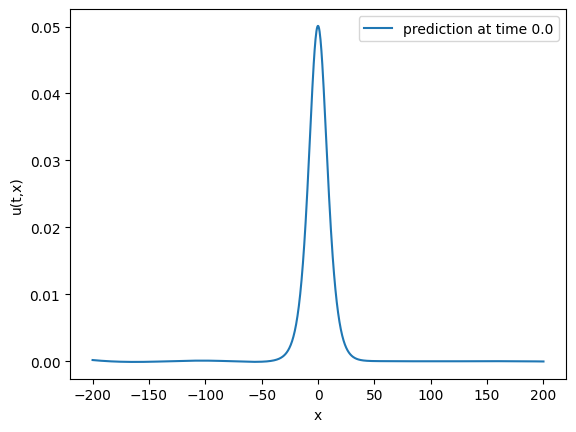

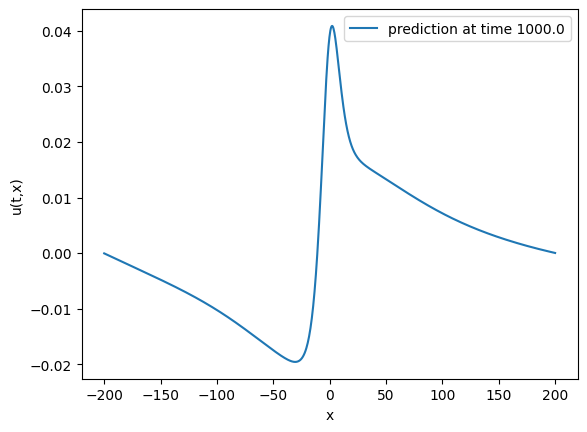

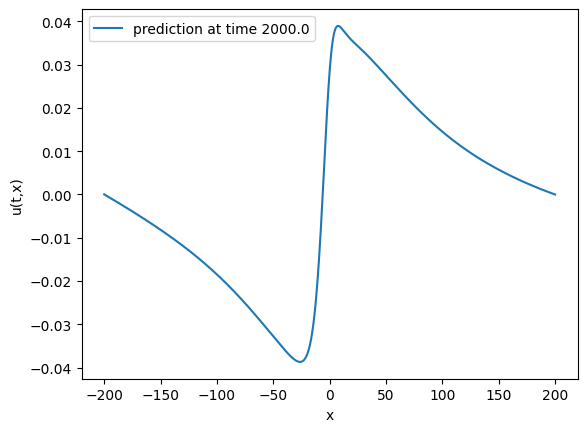

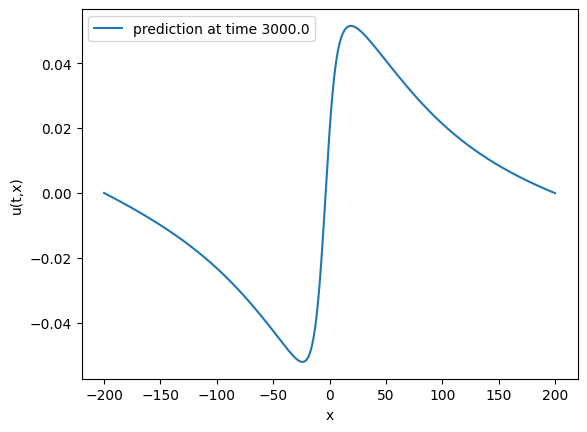

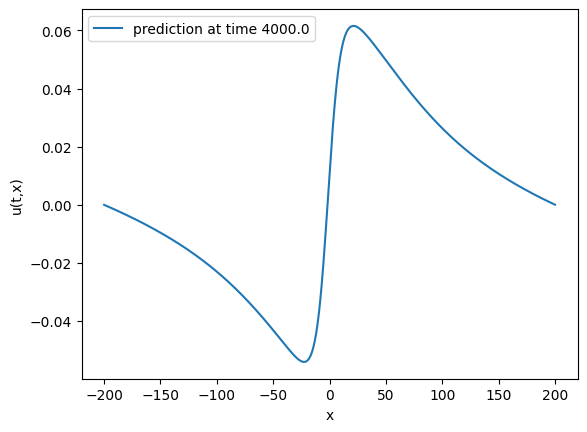

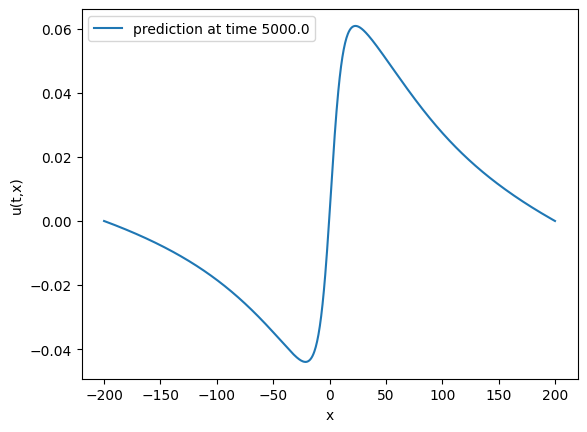

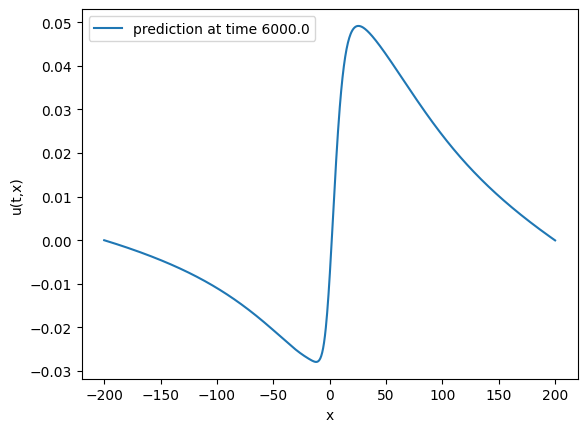

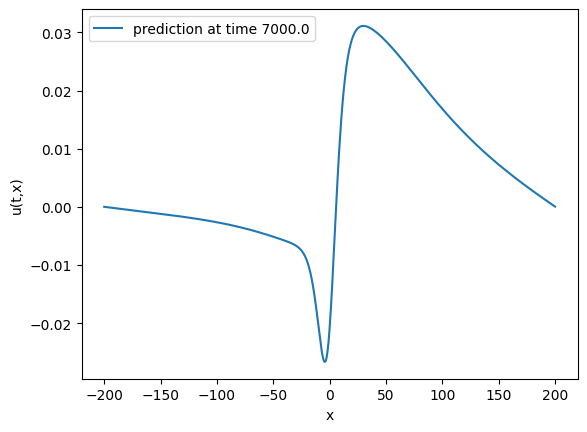

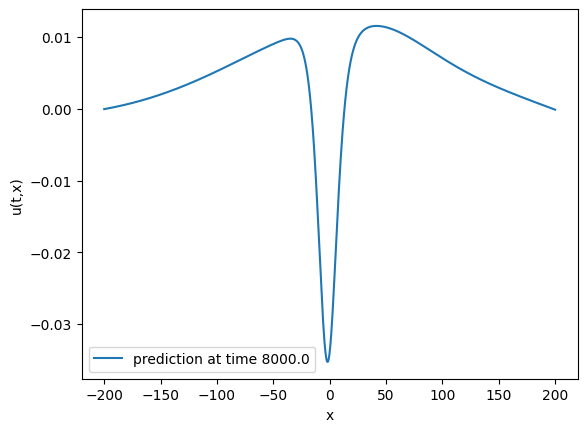

In [60]:
T = np.arange(0.,time+1000,1000.)
for inde, Tt in enumerate(T):
  plt.figure()
  plot_snapshots([Tt], phi_function = phi_function, pinn = pinn)
  # plt.savefig(str(os.getcwdb())[2:-1]+"/FinalPictures/1SolitonKdV/KdV1SolitonAddedTime"+str(inde)+".pdf",format ='pdf',bbox_inches="tight")

In [ ]:

# put the images into the frames variable
import imageio
frames = []
timesGIF = np.arange(0,10.5,0.5)
for inde, t in enumerate(T):
    image = imageio.v2.imread(str(os.getcwdb())[2:-1]+"/GIFs/KdVDoubleSolitonAdded/KdV2SolitonTime"+str(inde)+'.png')
    frames.append(image)
    print(t)


0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5
10.0


In [ ]:
# convert frames to GIF
GIFpath = str(os.getcwdb())[2:-1]+'/GIFs/KdVDoubleSolitonAdded.gif'
imageio.mimsave(GIFpath, # output gif
                frames,          # array of input frames
                fps = 5)         # optional: frames per second

In [ ]:
backbone2 = create_dense_model([32, 32, 32, 32, 32], activation='tanh', initializer='glorot_normal', \
    n_inputs=2, n_outputs=1)
pinn2 = KdVPinn(backbone2, k=6., loss_boundary_weight=1000.)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps= 1000, decay_rate=0.97)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler, clipnorm=1.)
pinn2.compile(optimizer=optimizer)

In [ ]:
(tx_eqn, y_eqn), (tx_init, y_init), (tx_boundary, y_boundary) = simulate_kdv(50000, phi_function3, boundary_function, x_start, length, t0+1., time+1., n_init = None, n_bnd = None, random_seed = 42, dtype=tf.float32)


In [ ]:
inputs = [tx_eqn, tx_init, tx_boundary, tx_boundary, tx_boundary]
outputs = [phi_function3(tx_eqn), y_eqn, pinn.backbone.predict(tx_init, batch_size=tx_init.shape[0]), y_boundary]

1/1 [==============================] - 0s 66ms/step


In [ ]:
history = pinn2.fit_custom(inputs, outputs, epochs = 20000, print_every = 500)

Epoch 0, Loss Residual: 0.0004, Loss Initial: 0.1730, Loss Boundary: 0.0919, MAE: 0.3185
Epoch 500, Loss Residual: 0.0023, Loss Initial: 0.0460, Loss Boundary: 0.0000, MAE: 0.0861
Epoch 1000, Loss Residual: 0.0016, Loss Initial: 0.0352, Loss Boundary: 0.0001, MAE: 0.0830
Epoch 1500, Loss Residual: 0.0021, Loss Initial: 0.0306, Loss Boundary: 0.0000, MAE: 0.0711
Epoch 2000, Loss Residual: 0.0022, Loss Initial: 0.0291, Loss Boundary: 0.0000, MAE: 0.0685
Epoch 2500, Loss Residual: 0.0021, Loss Initial: 0.0282, Loss Boundary: 0.0000, MAE: 0.0722
Epoch 3000, Loss Residual: 0.0023, Loss Initial: 0.0270, Loss Boundary: 0.0000, MAE: 0.0673
Epoch 3500, Loss Residual: 0.0021, Loss Initial: 0.0262, Loss Boundary: 0.0000, MAE: 0.0653
Epoch 4000, Loss Residual: 0.0021, Loss Initial: 0.0245, Loss Boundary: 0.0000, MAE: 0.0664
Epoch 4500, Loss Residual: 0.0025, Loss Initial: 0.0209, Loss Boundary: 0.0000, MAE: 0.0607
Epoch 5000, Loss Residual: 0.0025, Loss Initial: 0.0160, Loss Boundary: 0.0000, MAE:

In [ ]:
current_weights = pinn2.backbone.get_weights()
with open('KdVTripleSolitonTime1064-128-128-128-64.pickle', 'wb') as f:
    pickle.dump(current_weights, f)